In [28]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [29]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from datasets import train_test_random_split, load_celeba, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAECelebA, Classifier
from utils import latent_transversal, load_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [30]:
image_size = (64, 64)
dataset = ImageFolder('./celeba/', transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor()
                                ]))

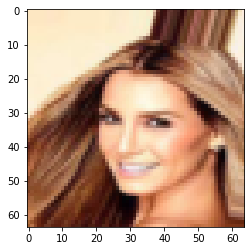

In [31]:
plt.imshow(dataset[0][0].permute(1, 2, 0).numpy())
plt.show()

In [32]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [33]:
data_train, data_test = train_test_random_split(dataset, 0.8)

batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [34]:
def train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device=None):
    model.train()

    train_loss = []
    for epoch in range(epochs):
        epoch_loss = []
        recon_losses = []
        for batch_idx, (data, _) in enumerate(train_loader):

            data = data.float()
            if device != None:
                data = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            recon, mu, logvar = model(data)
            loss, recon_loss = loss_beta_vae(recon, data, mu, logvar, beta, distribution)
            loss.backward()
            optimizer.step()
            # print statistics
            epoch_loss.append(loss.item())
            recon_losses.append(recon_loss.item())
        epoch_loss = np.mean(epoch_loss)
        recon_losses = np.mean(recon_losses)
        train_loss.append((epoch_loss, recon_losses,))
        print("Epoch " + str(epoch) + " finished, loss: " + str((epoch_loss, recon_losses,)))
    return train_loss


def test_beta_vae(model, test_loader, beta, distribution, device=None):
    model.eval()

    test_loss = []
    recon_losses = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.float()
            if device != None:
                data = data.to(device)
            # report the average loss over the test dataset
            recon, mu, logvar = model(data)
            loss, recon_loss = loss_beta_vae(recon, data, mu, logvar, beta, distribution)
            test_loss.append(loss.item())
            recon_losses.append(recon_loss.item())
    test_loss = np.mean(test_loss)
    recon_losses = np.mean(recon_losses)
    print("Test total loss: " + str(test_loss) + 'Test recon loss: ' + str(recon_losses))

In [45]:
model = BetaVAECelebA()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [49]:
# train the model
epochs = 10
beta = 250
distribution = 'gaussian'


In [47]:
import time

In [39]:
def plot_recon_image(model, dataset, index):
    plt.imshow(torch.sigmoid(model(dataset[index][0].view(1, 3, 64, 64).cuda())[0]).view(3,64,64).cpu().permute(1, 2, 0).detach().numpy())
    plt.show()

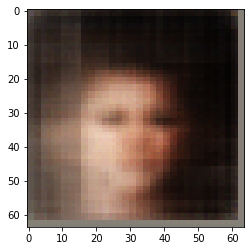

In [44]:
plot_recon_image(model, dataset, 3)

In [ ]:
start = time.time()
loss_list = []
losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
loss_list.append(losses)
save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e' + str(i+1) + '0.pth.tar', 
    loss_list, 10)
print('10 Epochs')
end = time.time()
print('time used in minutes:', (end-start)/60)

In [ ]:


print('Training started')
for i in range(10):
    losses = train_beta_vae(model, epochs, train_loader, optimizer, beta, distribution, device)
    loss_list.append(losses)
    save_checkpoint(model, optimizer, 'betavae_celeba_beta4_e' + str(i+1) + '0.pth.tar', 
        loss_list, (i+1)*10)
    print(str(i+1) + '0 Epochs')
    end = time.time()
    print('time used in minutes:', (end-start)/60)
print('Training finished')

end = time.time()